# Techniki inteligencji obliczeniowej – Multi Layer Perceptron

**Opis danych:** Zbiór danych MNIST zawiera obrazy cyfr odręcznych o rozmiarze 28×28 pikseli, używany do klasyfikacji cyfr od 0 do 9.

**Autorzy:** Adrian Broniecki, Mateusz Gazda

**Implementacja:** 
* Model został zaimplementowany na dwa sposoby: w czystym NumPy oraz przy użyciu biblioteki Keras (TensorFlow).

* Sieć jest typu **Multi Layer Perceptron (MLP)** z co najmniej jedną warstwą ukrytą, które wykorzystują funkcję aktywacji (**ReLU**).

* Wyjście modelu korzysta z funkcji softmax, która w przypadku problemu MNIST, umożliwia klasyfikację wieloklasową.

* Model może być trenowany przy użyciu stochastycznego spadku gradientu (SGD) lub optymalizatora Adam, zaś wagi są inicjalizowane metodą He initialization.

* Zastosowano również normalizację danych oraz opcjonalny dropout dla regularyzacji, aby ograniczyć nadmierne dopasowanie (ang. overfitting) do danych treningowych.


In [1]:
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from numpy_mlp import NumpyMLP
from keras_mlp import KerasMLP
from base_model import EarlyStopping, KerasEarlyStopping

MODE = 'keras'  # 'Keras' or 'Numpy'

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print(x_train.shape)
print(y_train.shape) 

(60000, 28, 28)
(60000,)


In [3]:
print(np.isnan(x_train).any())
print(np.isnan(y_train).any())

False
False


In [4]:
x_train = x_train.reshape((60000, 28 * 28)).astype('float32') / 255
x_test = x_test.reshape((10000, 28 * 28)).astype('float32') / 255

In [5]:
def my_to_categorical(y, num_classes=None):
    """
    Convert class vector (integers) to one-hot encoded matrix.
    
    Parameters:
    y : array-like of shape (n_samples,)
        Class labels as integers.
    num_classes : int, optional
        Total number of classes. If None, it is inferred from the data.
    
    Returns:
    onehot : ndarray of shape (n_samples, num_classes)
        One-hot encoded labels as float32.
    """
    y = np.asarray(y)
    if num_classes is None:
        num_classes = np.max(y) + 1

    onehot = np.zeros((y.shape[0], num_classes), dtype=np.float32)

    onehot[np.arange(y.shape[0]), y] = 1.0

    return onehot

In [6]:
y_train = my_to_categorical(y_train, num_classes=10)
y_test = my_to_categorical(y_test, num_classes=10)

In [7]:
x_train, x_val = x_train[:48000], x_train[48000:]
y_train, y_val = y_train[:48000], y_train[48000:]

In [8]:
def create_mlp(
    input_shape=(784,),
    hidden_units=[256, 128],
    activation='relu',
    dropout_rate=0.3,
    num_classes=10,
    backend=MODE,
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
):
    """
    Create a customizable MLP model with Keras or NumPy backend.

    Parameters:
    -----------
    input_shape : tuple
        Shape of the input vector (default 784 for MNIST flattened).
    hidden_units : list of int
        Number of neurons in each hidden layer (default [256, 128]).
    activation : str
        Activation function for hidden layers (e.g., 'relu', 'tanh', 'sigmoid').
    dropout_rate : float
        Dropout rate applied after each hidden layer (0 = no dropout).
    num_classes : int
        Number of output classes (default 10 for MNIST).
    backend : str
        Backend to use ('keras' or 'numpy').

    Returns:
    --------
    model : BaseModel 
        MLP model instance (KerasMLP or NumpyMLP).
    """
    backend = backend.lower()
    if backend == 'keras':
        return KerasMLP(
            input_shape=input_shape,
            hidden_units=hidden_units,
            activation=activation,
            dropout_rate=dropout_rate,
            num_classes=num_classes,
            loss=loss,
            optimizer=optimizer,
            metrics=metrics
        )
    elif backend == 'numpy':
        return NumpyMLP(
            input_shape=input_shape,
            hidden_units=hidden_units,
            activation=activation,
            dropout_rate=dropout_rate,
            num_classes=num_classes,
            loss=loss,
            metrics=metrics
        )
    else:
        raise ValueError("backend must be 'keras' or 'numpy'")

In [9]:
def train_model(model, x_train, y_train, x_val, y_val,
                optimizer='adam', loss='categorical_crossentropy',
                metrics=['accuracy'], epochs=15, batch_size=128,
                callbacks=None, verbose=1):
    """
    Train the MLP model. Works for both KerasMLP and NumpyMLP.

    Returns
    -------
    model : BaseModel
        Trained model instance
    history : History
        Training history object
    """
    if isinstance(model, NumpyMLP):
        history = model.fit(
            X_train=x_train,
            Y_train=y_train,
            validation_data=(x_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )
        return model, history
    
    elif isinstance(model, KerasMLP):
        # Select optimizer
        if optimizer.lower() == 'adam':
            opt = tf.keras.optimizers.Adam()
        elif optimizer.lower() == 'sgd':
            opt = tf.keras.optimizers.SGD()
        else:
            opt = tf.keras.optimizers.get(optimizer)

        model._model.compile(optimizer=opt,
                             loss=loss,
                             metrics=metrics)

        history_obj = model.fit(x_train, y_train,
                                validation_data=(x_val, y_val),
                                epochs=epochs,
                                batch_size=batch_size,
                                callbacks=callbacks,
                                verbose=1)
        return model, history_obj

    else:
        raise ValueError("Unsupported model type. Must be NumpyMLP or KerasMLP.")


In [10]:
def hyperparameter_search(x_train, y_train, x_val, y_val,
                          hidden_units_list=[[128], [256, 128]],
                          activations=['relu', 'tanh'],
                          dropout_rates=[0.0, 0.3, 0.5],
                          optimizers=['adam', 'sgd'],
                          losses=['categorical_crossentropy'],
                          metrics_list=[['accuracy', 'precision', 'recall', 'TopKCategoricalAccuracy']],
                          epochs=[5, 10, 15, 20],
                          batch_size=128,
                          backend=MODE,
                          early_stopping=True,
                          patience=5):
    results = []

    for hidden_units, activation, dropout_rate, optimizer, loss, metrics, epochs_n in itertools.product(
        hidden_units_list, activations, dropout_rates, optimizers, losses, metrics_list, epochs
    ):
        print(f"Testing: hidden_units={hidden_units}, activation={activation}, dropout={dropout_rate}, optimizer={optimizer}, loss={loss}, epochs={epochs_n}")

        model = create_mlp(hidden_units=hidden_units, activation=activation, dropout_rate=dropout_rate, metrics=metrics, backend=backend)

        cb_list = []
        if early_stopping:
            if isinstance(model, NumpyMLP):
                cb_list.append(EarlyStopping(monitor='val_accuracy', patience=patience, mode='max'))

            if isinstance(model, KerasMLP):
                cb_list.append(KerasEarlyStopping(monitor='val_accuracy', patience=5, mode='max'))


        trained_model, history = train_model(
            model, x_train, y_train, x_val, y_val,
            optimizer=optimizer,
            loss=loss,
            epochs=epochs_n,
            batch_size=batch_size,
            callbacks=cb_list
        )

        if isinstance(history, dict):
            val_acc = max(history.get('val_accuracy', [0]))
        else:
            val_acc = max(history.history.get('val_accuracy', [0]))

        results.append({
            'hidden_units': hidden_units,
            'activation': activation,
            'dropout_rate': dropout_rate,
            'optimizer': optimizer,
            'loss': loss,
            'metrics': metrics,
            'epochs': epochs_n,
            'val_accuracy': val_acc,
            'model': trained_model,
            'history': history
        })

    return pd.DataFrame(results)



# results = hyperparameter_search(
#     x_train, y_train,
#     x_val, y_val,
#     hidden_units_list=[[128], [256,128]],
#     activations=['relu', 'tanh'],
#     dropout_rates=[0.0, 0.3],
#     optimizers=['adam', 'sgd'],
#     losses=['categorical_crossentropy'],
#     metrics_list=[['accuracy'], ['accuracy','TopKCategoricalAccuracy']],
#     epochs=[5, 10, 15, 20]
# )

results = hyperparameter_search(
    x_train, y_train,
    x_val, y_val,
    hidden_units_list=[[256,128]],
    activations=['relu'],
    dropout_rates=[0.3],
    optimizers=['adam'],
    losses=['categorical_crossentropy'],
    metrics_list=[['accuracy', 'precision', 'recall', 'TopKCategoricalAccuracy']],
    epochs=[20]
)

results_sorted = results.sort_values(by='val_accuracy', ascending=False)
print(results_sorted.head(10))

Testing: hidden_units=[256, 128], activation=relu, dropout=0.3, optimizer=adam, loss=categorical_crossentropy, epochs=20
Epoch 1/20


c:\Users\Adrian\Desktop\Magisterka\SEMESTR2\TIO\Labolatorium\TIO\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8676 - loss: 0.4297 - val_accuracy: 0.9534 - val_loss: 0.1548
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9461 - loss: 0.1786 - val_accuracy: 0.9672 - val_loss: 0.1089
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9609 - loss: 0.1337 - val_accuracy: 0.9720 - val_loss: 0.0935
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9672 - loss: 0.1083 - val_accuracy: 0.9734 - val_loss: 0.0905
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9711 - loss: 0.0918 - val_accuracy: 0.9748 - val_loss: 0.0787
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9751 - loss: 0.0811 - val_accuracy: 0.9760 - val_loss: 0.0799
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9791 - loss: 0.0685 - val_accuracy: 0.9749 - val_loss: 0.0822
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9793 - loss: 0.0653 - val_accuracy: 0.9777 - val_

In [11]:
def plot_learning_curves(history):
    """
    Plot train and validation accuracy/loss curves from history.
    Works for both Keras History object and dict (NumPyMLP).
    """
    if hasattr(history, 'history'):
        hist = history.history
    else:
        hist = history
    
    plt.figure(figsize=(12,4))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(hist['accuracy'], label='Train')
    plt.plot(hist.get('val_accuracy', []), label='Validation')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    if 'loss' in hist:
        plt.plot(hist['loss'], label='Train')
        plt.plot(hist.get('val_loss', []), label='Validation')
    else:
        plt.plot([None]*len(hist['accuracy']), label='Train')
        plt.plot([None]*len(hist.get('val_accuracy', [])), label='Validation')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

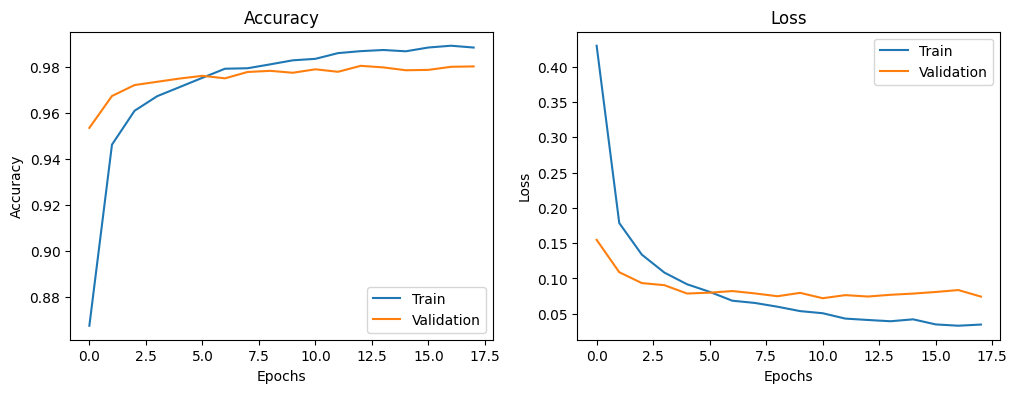

In [12]:
best_row = results_sorted.iloc[0]
best_model = best_row['model']
best_history = best_row['history']

plot_learning_curves(best_history)

In [13]:
def evaluate_model(model, x_test, y_test, top_n_wrong=10):
    results_dict = model.evaluate(x_test, y_test)

    print("Evaluation results:")
    for metric in model.metrics:
        value = results_dict.get(metric)
        if value is not None:
            print(f"{metric}: {value:.4f}")

    y_pred_probs = model.predict(x_test)
    y_pred_labels = np.argmax(y_pred_probs, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)

    wrong = np.where(y_pred_labels != y_true_labels)[0]
    print(f"Number of misclassified examples: {len(wrong)}")

    plt.figure(figsize=(12,6))
    for i, idx in enumerate(wrong[:top_n_wrong]):
        plt.subplot(2, top_n_wrong//2, i+1)
        plt.imshow(x_test[idx].reshape(28,28), cmap='gray')
        plt.title(f"True:{y_true_labels[idx]}, Pred:{y_pred_labels[idx]}")
        plt.axis('off')
    plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Evaluation results:
accuracy: 0.9785
precision: 0.9785
recall: 0.9785
TopKCategoricalAccuracy: 0.9996
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
Number of misclassified examples: 215


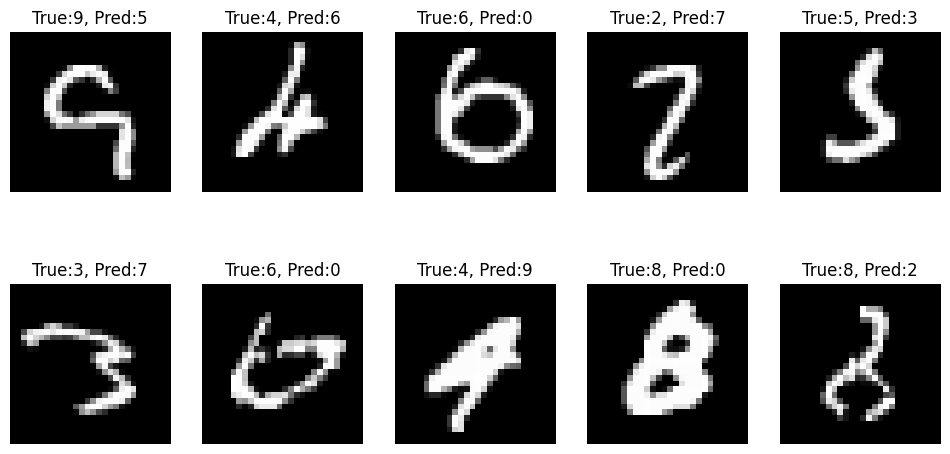

In [14]:
evaluate_model(best_model, x_test, y_test)